#Recommender System Coursework(2438322X)

## Setup block

Setup the data files, Python etc.

In [1]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  6275k      0  0:00:01  0:00:01 --:--:-- 6275k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  2667k      0 --:--:-- --:--:-- --:--:-- 2664k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  6936k      0  0:00:01  0:00:01 --:--:-- 6936k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  2139k      0 --:--:-- --:--:-- --:--:-- 2136k


In [2]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions
from spotlight.evaluation import mrr_score
from collections import defaultdict

  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-7cj27otw/spotlight
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-7cj27otw/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp36-none-any.whl size=34096 sha256=1d56840ca246f78b17d8c640dac65f0d3bd47302755d3bc18d57c1222fa4a266
  Stored in directory: /tmp/pip-ephem-wheel-cache-okf04zlu/wheels/22/6f/f1/68cc6c5b563e78737e4a8fed63ddc105a3baf25d2abccae0c6
Successfully built spotlight



# data preparation

In [0]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [0]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")

ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


In [5]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)
test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(42))


num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Question 1

In [6]:
import collections
#Average rating after mapped
average_rating = ratings_df.groupby(["book_id"]).mean().rating
dic_average = {}
for index in average_rating.index:
  temp = iid_map[index]
  dic_average[temp] = average_rating[index]
dic_average_order = collections.OrderedDict(sorted(dic_average.items()))
average_rating_mapped = list(dic_average_order.values())

#Number of ratings after mapped
num_ratings = books_df[['ratings_count','book_id']]
num_rating_mapped = np.zeros(num_items)
for index in range(0, num_items):
  num_rating_mapped[index] += float(num_ratings[num_ratings["book_id"] == iid_rev_map[index]].ratings_count)

#Number of 5* ratings after mapped
ratings_5_num = books_df[['ratings_5','book_id']]
ratings_5_mapped = np.zeros(num_items)
for index in range(0, num_items):
  ratings_5_mapped[index] += float(ratings_5_num[ratings_5_num["book_id"] == iid_rev_map[index]].ratings_5)

#Fraction of 5* ratings after mapped
fraction_ratings_5 = books_df[['ratings_5','ratings_count','book_id']]
fraction_ratings_5['fraction'] = fraction_ratings_5['ratings_5']/fraction_ratings_5['ratings_count']
fraction_ratings_5_mapped = np.zeros(num_items)
for index in range(0, num_items):
  fraction_ratings_5_mapped[index] += float(fraction_ratings_5[fraction_ratings_5["book_id"] == iid_rev_map[index]].fraction)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
#Four models using the variables above
class AverageModel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)

  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    self.predictions = np.array(average_rating_mapped)
    return( self.predictions )

class ratingNumModel:
  
  def __init__(self, numitems):
    self.prediction=np.zeros(numitems)

  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    self.prediction = np.array(num_rating_mapped)
    return( self.prediction )

class rating_5_Model:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)

  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    self.predictions = np.array(ratings_5_mapped)
    return( self.predictions )

class FractionModel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)

  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    self.predictions = np.array(fraction_ratings_5_mapped)
    return( self.predictions )
print("The MRR score for average model is:",mrr_score(AverageModel(num_items), test_dataset, train=rating_dataset, k=100).mean())
print("The MRR score for rating num model is:",mrr_score(ratingNumModel(num_items), test_dataset, train=rating_dataset, k=100).mean())
print("The MRR score for rating_5 model is:",mrr_score(rating_5_Model(num_items), test_dataset, train=rating_dataset, k=100).mean())
print("The MRR score for fraction_5 model is:",mrr_score(FractionModel(num_items), test_dataset, train=rating_dataset, k=100).mean())



The MRR score for average model is: 0.015052024168984034
The MRR score for rating num model is: 0.2396001188245477
The MRR score for rating_5 model is: 0.2409670879930144
The MRR score for fraction_5 model is: 0.03415267465103555


#Question 2


In [0]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel

In [0]:
#Use the explicit factorization model to train the explicit dataset
explicit_model = ExplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1))
explicit_model.fit(rating_dataset)
mrr_explicit = mrr_score(explicit_model, test_dataset, train=rating_dataset, k=100, verbose=True).mean()
print("The MRR score of explicit factorization model which trained on explicit dataset is:",mrr_explicit, flush=True)

1999it [00:02, 907.89it/s]

The MRR score of explicit factorization model which trained on explicit dataset is: 0.05502920579265286


In [0]:
#Use the implicit factorization model to train the explicit dataset
implicit_model = ImplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1), loss='bpr')
implicit_model.fit(rating_dataset)
mrr_implicit = mrr_score(implicit_model, test_dataset, train=rating_dataset, k=100, verbose=True).mean()
print("The MRR score of implicit factorization model which trained on explicit dataset is:",mrr_implicit, flush=True)

1999it [00:02, 912.43it/s]

The MRR score of implicit factorization model which trained on explicit dataset is: 0.39197275679633103


In [0]:
#Tune the latent factor among 8,16,32,64
implicit_model_8 = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1),loss='bpr',embedding_dim=8)
implicit_model_8.fit(rating_dataset)
mrr_implicit_8 = mrr_score(implicit_model_8, validation, train=rating_dataset, k=100).mean()
print("The MRR score of implicit model with latent factor 8 on explicit data is :",mrr_implicit_8)

implicit_model_16 = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1),loss='bpr',embedding_dim=16)
implicit_model_16.fit(rating_dataset)
mrr_implicit_16 = mrr_score(implicit_model_16, validation, train=rating_dataset,  k=100).mean()
print("The MRR score of implicit model with latent factor 16 on explicit data is :",mrr_implicit_16)

implicit_model_32 = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1),loss='bpr',embedding_dim=32)
implicit_model_32.fit(rating_dataset)
mrr_implicit_32 = mrr_score(implicit_model_32, validation, train=rating_dataset, k=100).mean()
print("The MRR score of implicit model with latent factor 32 on explicit data is :",mrr_implicit_32)

implicit_model_64 = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1),loss='bpr',embedding_dim=64)
implicit_model_64.fit(rating_dataset)
mrr_implicit_64 = mrr_score(implicit_model_64, validation, train=rating_dataset, k=100).mean()
print("The MRR score of implicit model with latent factor 64 on explicit data is :",mrr_implicit_64)


The MRR score of implicit model with latent factor 8 on explicit data is : 0.01593859387425898
The MRR score of implicit model with latent factor 16 on explicit data is : 0.016254096382993945
The MRR score of implicit model with latent factor 32 on explicit data is : 0.014930964036171614
The MRR score of implicit model with latent factor 64 on explicit data is : 0.014370484397310085


In [9]:
#So the best model is the model of 16 latent factors.
mrr_bestModel = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1),loss='bpr',embedding_dim=16)
mrr_bestModel.fit(rating_dataset)
mrr_implicit_best_score = mrr_score(mrr_bestModel, test_dataset, train=rating_dataset, k=100).mean()
print("The MRR score of the best implicit model is :", mrr_implicit_best_score)

The MRR score of the best implicit model is : 0.3887596323416617


#Question 3

In [0]:
#Use the implicit factorization model to train the implicit dataset
implicit_model_8_imp = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1), loss='bpr',embedding_dim=8)
implicit_model_8_imp.fit(toread_dataset_train)
mrr_implicit_8_imp = mrr_score(implicit_model_8_imp, validation, train=toread_dataset_train, k=100).mean()
print("The MRR score of implicit model with latent factor 8 on implicit data is :",mrr_implicit_8_imp, flush=True)

implicit_model_16_imp = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1), loss='bpr',embedding_dim=16)
implicit_model_16_imp.fit(toread_dataset_train)
mrr_implicit_16_imp = mrr_score(implicit_model_16_imp, validation, train=toread_dataset_train, k=100).mean()
print("The MRR score of implicit model with latent factor 16 on implicit data is :",mrr_implicit_16_imp, flush=True)

implicit_model_32_imp = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1), loss='bpr',embedding_dim=32)
implicit_model_32_imp.fit(toread_dataset_train)
mrr_implicit_32_imp = mrr_score(implicit_model_32_imp, validation, train=toread_dataset_train, k=100).mean()
print("The MRR score of implicit model with latent factor 32 on implicit data is :",mrr_implicit_32_imp, flush=True)

implicit_model_64_imp = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1), loss='bpr',embedding_dim=64)
implicit_model_64_imp.fit(toread_dataset_train)
mrr_implicit_64_imp = mrr_score(implicit_model_64_imp, validation, train=toread_dataset_train, k=100).mean()
print("The MRR score of implicit model with latent factor 64 on implicit data is :",mrr_implicit_64_imp, flush=True)


The MRR score of implicit model with latent factor 8 on implicit data is : 0.30312751788139053
The MRR score of implicit model with latent factor 16 on implicit data is : 0.31596077294142055
The MRR score of implicit model with latent factor 32 on implicit data is : 0.31390498019752316
The MRR score of implicit model with latent factor 64 on implicit data is : 0.3105404553562472


In [10]:
#As shown above, the best implicit model is on the latent factor 16
implicit_model_best_imp = ImplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1), loss='bpr',embedding_dim=16)
implicit_model_best_imp.fit(toread_dataset_train)
mrr_implicit_best_imp = mrr_score(implicit_model_best_imp, test_dataset, train=toread_dataset_train, k=100).mean()
print("The MRR score of best implicit model with latent factor 16 on implicit data is :",mrr_implicit_best_imp, flush=True)

The MRR score of best implicit model with latent factor 16 on implicit data is : 0.35111200410960436


In [0]:

import scipy.stats as st
#Provide examples of userids for which the system attained the highest RR score. 
#Use the best model with latent factor 16 to calculate the RR score and rank the score from every user
RR_16 = mrr_score(implicit_model_best_imp, test_dataset, train=toread_dataset_train, k=100)
RR_ranks = st.rankdata(-RR_16, method='min')

def countRatings(uid, rr):
  print("User with id %d with RR %f had %d ratings" %( uid, rr, len(toread_iids[toread_uids==uid])))
  
  #The best implicit model predicts the books which one user likes
  user_ranks = st.rankdata(-implicit_model_best_imp.predict(uid))
  num = 0
  topRank_list = []
  for item_id in np.argwhere(user_ranks <= 30):
    topRank_list.append(item_id)
  
  #Calculate the books which the model predicts correctly
  test_value = test_iids[test_uids == uid]
  count = 0
  for i in test_value:
    for j in range(0,len(topRank_list)):
      if (topRank_list[j] == i):
        count+=1

  print("The user %d actually put %d books on the shelves!" %(uid, len(test_value)))
  print("The model predicts ",count," books correctly in top rank 30 books!")
  print("-------------------------------------------------------------")

for x in range(0,len(np.argwhere(RR_ranks==1))):
  countRatings(np.argwhere(RR_ranks==1).item(x), RR_16[RR_ranks==1].item(x))


User with id 1 with RR 1.000000 had 96 ratings
The user 1 actually put 18 books on the shelves!
The model predicts  4  books correctly in top rank 30 books!
-------------------------------------------------------------
User with id 10 with RR 1.000000 had 65 ratings
The user 10 actually put 23 books on the shelves!
The model predicts  3  books correctly in top rank 30 books!
-------------------------------------------------------------
User with id 11 with RR 1.000000 had 82 ratings
The user 11 actually put 14 books on the shelves!
The model predicts  5  books correctly in top rank 30 books!
-------------------------------------------------------------
User with id 14 with RR 1.000000 had 54 ratings
The user 14 actually put 12 books on the shelves!
The model predicts  1  books correctly in top rank 30 books!
-------------------------------------------------------------
User with id 24 with RR 1.000000 had 81 ratings
The user 24 actually put 19 books on the shelves!
The model predicts  

In [0]:
#Ackonwledge:Part of code is from the lab solution
#implement the Intra-list diversity measure of top 5 books
import scipy.stats as st
 
def tracksForUser(uid):
  item_vector = []
  user_ranks = st.rankdata(-implicit_model_best_imp.predict(uid))
  for iid in np.argwhere(user_ranks <= 5):
    # print(implicit_model_best_imp._net.item_embeddings.weight[iid.item(0)])
    item_vector.append(implicit_model_best_imp._net.item_embeddings.weight[iid.item(0)])
  return item_vector



In [0]:
#Calculate the Intra-list diversity scores
import torch.nn as nn
def intra_list_score(item_list):
  count_cosine = 0
  for i in range(4):
    for j in range(i+1,4):
      count_cosine += (1-nn.functional.cosine_similarity(item_list[i],item_list[j],dim=0))
  return 2*count_cosine/5/4


In [0]:
intra_score = []
for i in uid_map.values():
  intra_score.append(intra_list_score(tracksForUser(i)))
intra_score_array = np.array(intra_score)
intra_score_max = intra_score_array.max()
intra_score_min = intra_score_array.min()

#Use the best model to predict the user who get the lowest intra_list score to get the top 5 books' names 
min_intra_book = np.argwhere(st.rankdata(-implicit_model_best_imp.predict(np.argwhere(intra_score_array==intra_score_min.item())[0][0]))<=5)
for i in min_intra_book:
  print(books_df[books_df['book_id']==iid_rev_map[i.item()]].original_title)

#Use the best model to predict the user who get the highest intra_list score to get the top 5 books' names 
max_intra_book = np.argwhere(st.rankdata(-implicit_model_best_imp.predict(np.argwhere(intra_score_array==intra_score_max.item())))<=5)
for i in max_intra_book:
  print(books_df[books_df['book_id']==iid_rev_map[i.item()]].original_title)

17    Harry Potter and the Prisoner of Azkaban
Name: original_title, dtype: object
1    Harry Potter and the Philosopher's Stone
Name: original_title, dtype: object
22    Harry Potter and the Chamber of Secrets
Name: original_title, dtype: object
23    Harry Potter and the Goblet of Fire
Name: original_title, dtype: object
24    Harry Potter and the Deathly Hallows
Name: original_title, dtype: object
23    Harry Potter and the Goblet of Fire
Name: original_title, dtype: object
125    Dune
Name: original_title, dtype: object
639    Definitely Dead (Sookie Stackhouse, #6)
Name: original_title, dtype: object
1204    Children of Dune
Name: original_title, dtype: object
192    Outliers: The Story of Success
Name: original_title, dtype: object


#Question 4

In [0]:
#mrr_bestModel,implicit_model_best_imp
class comb_Sum:

  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    user_sum = mrr_bestModel.predict(uid) + implicit_model_best_imp.predict(uid)
    self.predictions = np.array(user_sum)
    return(self.predictions)


In [0]:
combSum_rr_score_Q2 = mrr_score(comb_Sum(num_items), test_dataset, k=100)
combSum_mrr_score_Q2 = combSum_rr_score_Q2.mean()

In [0]:
RR_Q2 = mrr_score(mrr_bestModel, test_dataset, train=rating_dataset, k=100)
RR_Q3 = mrr_score(implicit_model_best_imp, test_dataset, train=toread_dataset_train, k=100)


In [0]:
#Count the improvement number of users
count_improve = 0
for i in iid_map.values():
  if(combSum_rr_score_Q2[i] > RR_Q2[i] and combSum_rr_score_Q2[i] > RR_Q2[i]):
    count_improve+=1

In [0]:
count_improve

345

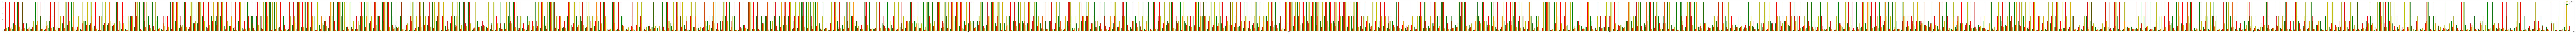

In [0]:
#Plot the figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
index=np.arange(num_users)
fig = plt.figure(num=None, figsize=(500, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, combSum_rr_score_Q2, label="combSum", color='y', width=0.25)
plt.bar(index+0.25, RR_Q2, label="Q2", color='r', width=0.25 )
plt.bar(index+0.5, RR_Q3, label="Q3", color='g', width=0.25)
plt.xlabel('user')
plt.ylabel('RR score')
plt.legend()
plt.xlim([0,2000])
plt.show()

#Question 5

In [11]:
#Acknowledge: This part of code is from the LAB 1 solution.
positives=ratings_df[ratings_df["rating"]>=4]

pairs = pd.merge(positives, positives, on=["user_id"])

# pairs = pairs[pairs['book_id_x']>pairs['book_id_y']]

# sequences=pairs[pairs["rating_x"] < pairs["rating_y"]]

paircounts = pairs[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()

pairswithcounts = paircounts.reset_index().rename(columns={"user_id" : "count"}).sort_values(['count'], ascending=False)

#pairswithcounts = pairswithcounts[pairswithcounts["book_id_x"]!=pairswithcounts["book_id_y"]]

pairs

,Unnamed: 0_x,user_id,book_id_x,rating_x,Unnamed: 0_y,book_id_y,rating_y
0,0,1,258,5,0,258,5
1,0,1,258,5,156628,33,4
2,0,1,258,5,156635,70,5
3,0,1,258,5,156644,45,5
4,0,1,258,5,58,1796,5
...,...,...,...,...,...,...,...
3731561,428645,1401,279,4,407891,459,4
3731562,428645,1401,279,4,395145,1198,4
3731563,428645,1401,279,4,426652,1345,4
3731564,428645,1401,279,4,435917,1508,4


In [12]:
#Acknowledge: This part of code is from the LAB 1 solution.
bookCounts = positives.groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratingCount"})
#bookCounts
allstats = pairswithcounts.merge(bookCounts, left_on="book_id_x", right_on="book_id").merge(bookCounts, left_on="book_id_y", right_on="book_id")
#allstats
allstats = allstats[["book_id_x",	"book_id_y",	"count", "ratingCount_x", "ratingCount_y"]]
#allstats
allstats = allstats.loc[:,~allstats.columns.duplicated()]
#allstats
num=float(ratings_df.count()["rating"])
#num
allstats["lift"] =(allstats["count"] / num ) / ( (allstats["ratingCount_x"] / num) * (allstats["ratingCount_y"] / num))
#allstats
#withtitles = allstats.merge(ratings_df, left_on=["book_id_x"], right_on="book_id").merge(ratings_df, left_on=["book_id_y"], right_on="book_id")

allstats.sort_values(['lift'], ascending=False)
allstats

,book_id_x,book_id_y,count,ratingCount_x,ratingCount_y,lift
0,4,4,528,528,528,236.291667
1,1,4,134,502,528,63.073871
2,25,4,169,453,528,88.152962
3,18,4,170,414,528,97.027979
4,8,4,185,408,528,107.142055
...,...,...,...,...,...,...
1078823,980,1840,1,9,1,13862.444444
1078824,1901,1840,1,7,1,17823.142857
1078825,1962,1840,1,7,1,17823.142857
1078826,433,1840,1,7,1,17823.142857


In [0]:
import collections
class lift_Model:
  def __init__(self, numitems, threshold):
    self.predictions=defaultdict(int)
    #All the real book id 
    all_book_id = books_df.book_id.values
    #Create the collection to store the lift value of every book
    self.dic_book_pair = defaultdict(int)
    allstats_threshold = allstats[allstats['ratingCount_x'] > threshold]
    allstats_threshold = allstats_threshold[allstats_threshold["book_id_x"]!=allstats_threshold["book_id_y"]]
    allstats_threshold_array = np.array(allstats_threshold)
    for index in range(0,allstats_threshold_array.shape[0]):
      self.dic_book_pair[allstats_threshold_array[index][0],allstats_threshold_array[index][1]] = allstats_threshold_array[index][5]
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #The real book id which users have rated
    rated_item_id_df = ratings_df[ratings_df["user_id"]==uid_rev_map[uid]]
    rated_item_id = ratings_df[ratings_df["user_id"]==uid_rev_map[uid]].book_id.values
    positive_for_user = rated_item_id_df[rated_item_id_df.rating>=4].book_id.values
    #The real book id which users have not rated
    no_rated_item_id = books_df[~books_df.book_id.isin(rated_item_id)].book_id.values
    all_book_id = books_df.book_id.values
    # print(rated_item_id)
    print("The number of books the user",uid,"have rated is :",len(rated_item_id))
    # print(all_book_id)
    print("The number of all books is:",len(all_book_id))
    # print(no_rated_item_id)
    # print("The number of books the user",uid,"has not rated is :",len(no_rated_item_id))

    #calculate the sum of lift for target books
    for i in all_book_id:
      sum = 0
      if i in rated_item_id:
        self.predictions[i] = sum
      else:
        for j in positive_for_user:
          if (self.dic_book_pair[i,j]==0):
            continue
          else:
            sum += np.log10(self.dic_book_pair[i,j])
        self.predictions[i] = sum

    #Mapped the book id
    dic = defaultdict(int)
    for index in all_book_id:
      temp = iid_map[index]
      dic[temp] = self.predictions[index]
    dic_order = collections.OrderedDict(sorted(dic.items()))
    predictions_mapped = list(dic_order.values())
    return(np.array(predictions_mapped))



    

In [0]:
#Online
lift = lift_Model(num_items,0)
lift.predict(1)

The number of books the user 1 have rated is : 84
The number of all books is: 1826
The number of books the user 1 has not rated is : 1742


array([90.65082177, 64.72812414, 26.33870237, ...,  8.45752393,
       43.38190395, 14.47955747])

In [0]:
#Calculate the MRR score for lift model without the threshold
print("The MRR score is:",mrr_score(lift_Model(num_items,0), test_dataset,k=100).mean())

流式输出内容被截断，只能显示最后 5000 行内容。
The number of books the user 333 have rated is : 73
The number of all books is: 1826
The number of books the user 333 has not rated is : 1753
The number of books the user 334 have rated is : 56
The number of all books is: 1826
The number of books the user 334 has not rated is : 1770
The number of books the user 335 have rated is : 33
The number of all books is: 1826
The number of books the user 335 has not rated is : 1793
The number of books the user 336 have rated is : 30
The number of all books is: 1826
The number of books the user 336 has not rated is : 1796
The number of books the user 337 have rated is : 67
The number of all books is: 1826
The number of books the user 337 has not rated is : 1759
The number of books the user 338 have rated is : 65
The number of all books is: 1826
The number of books the user 338 has not rated is : 1761
The number of books the user 339 have rated is : 25
The number of all books is: 1826
The number of books the user 339 has

In [0]:
#Starting from the middle of max rating times
ratingCount_max = allstats.loc[:,'ratingCount_x'].max()
mrr_threshold = []
for i in range(0,int(ratingCount_max),int(ratingCount_max/2-1)):
  #print the mrr score when threshold is (0,263,526)
  mrr_threshold_per = mrr_score(lift_Model(num_items,i), validation, k=100).mean()
  print(mrr_threshold_per)
  mrr_threshold.append(mrr_threshold_per)
print(mrr_threshold)

流式输出内容被截断，只能显示最后 5000 行内容。
The number of all books is: 1826
The number of books the user 333 has not rated is : 1753
The number of books the user 334 have rated is : 56
The number of all books is: 1826
The number of books the user 334 has not rated is : 1770
The number of books the user 335 have rated is : 33
The number of all books is: 1826
The number of books the user 335 has not rated is : 1793
The number of books the user 336 have rated is : 30
The number of all books is: 1826
The number of books the user 336 has not rated is : 1796
The number of books the user 337 have rated is : 67
The number of all books is: 1826
The number of books the user 337 has not rated is : 1759
The number of books the user 338 have rated is : 65
The number of all books is: 1826
The number of books the user 338 has not rated is : 1761
The number of books the user 339 have rated is : 25
The number of all books is: 1826
The number of books the user 339 has not rated is : 1801
The number of books the user 34

In [0]:
#The MRR score fot threshold(0,314,628) is decreasing (0.016462661290507826, 0.010455972478818267, 0.002001000500250125), so we need to print the threshold when it is between 0 and 264
mrr_threshold2 = []
for i in range(0,int(ratingCount_max/2),int(ratingCount_max/4)-1):
  #print the mrr score when threshold is (0,131,262)
  mrr_threshold_per = mrr_score(lift_Model(num_items,i), validation, k=100).mean()
  print(mrr_threshold_per)
  mrr_threshold2.append(mrr_threshold_per)
print(mrr_threshold2)

流式输出内容被截断，只能显示最后 5000 行内容。
The number of all books is: 1826
The number of books the user 333 has not rated is : 1753
The number of books the user 334 have rated is : 56
The number of all books is: 1826
The number of books the user 334 has not rated is : 1770
The number of books the user 335 have rated is : 33
The number of all books is: 1826
The number of books the user 335 has not rated is : 1793
The number of books the user 336 have rated is : 30
The number of all books is: 1826
The number of books the user 336 has not rated is : 1796
The number of books the user 337 have rated is : 67
The number of all books is: 1826
The number of books the user 337 has not rated is : 1759
The number of books the user 338 have rated is : 65
The number of all books is: 1826
The number of books the user 338 has not rated is : 1761
The number of books the user 339 have rated is : 25
The number of all books is: 1826
The number of books the user 339 has not rated is : 1801
The number of books the user 34

In [0]:
#The MRR score fot threshold(0,131,262) is decreasing(0.016462661290507826, 0.016221796850339743, 0.010455972478818267), so we need to print the threshold when it is between 0 and 157
mrr_threshold3 = []
for i in range(0,int(ratingCount_max/4),int(ratingCount_max/8)-1):
  #print the mrr score when threshold is (0,65,130)
  mrr_threshold_per = mrr_score(lift_Model(num_items,i), validation, k=100).mean()
  print(mrr_threshold_per)
  mrr_threshold3.append(mrr_threshold_per)
print(mrr_threshold3)

流式输出内容被截断，只能显示最后 5000 行内容。
The number of all books is: 1826
The number of books the user 333 has not rated is : 1753
The number of books the user 334 have rated is : 56
The number of all books is: 1826
The number of books the user 334 has not rated is : 1770
The number of books the user 335 have rated is : 33
The number of all books is: 1826
The number of books the user 335 has not rated is : 1793
The number of books the user 336 have rated is : 30
The number of all books is: 1826
The number of books the user 336 has not rated is : 1796
The number of books the user 337 have rated is : 67
The number of all books is: 1826
The number of books the user 337 has not rated is : 1759
The number of books the user 338 have rated is : 65
The number of all books is: 1826
The number of books the user 338 has not rated is : 1761
The number of books the user 339 have rated is : 25
The number of all books is: 1826
The number of books the user 339 has not rated is : 1801
The number of books the user 34

In [0]:
#The MRR score fot threshold(0,65,131) is decreasing (0.011233581567168933, 0.011229983569007233, 0.009604375643553173), so we need to print the threshold when it is between 0 and 157
mrr_threshold4 = []
for i in range(0,int(ratingCount_max/8),int(ratingCount_max/16)-1):
  #print the mrr score when threshold is (0,32,65)
  mrr_threshold_per = mrr_score(lift_Model(num_items,i), validation, k=100).mean()
  print(mrr_threshold_per)
  mrr_threshold4.append(mrr_threshold_per)
print(mrr_threshold4)

流式输出内容被截断，只能显示最后 5000 行内容。
The number of all books is: 1826
The number of books the user 333 has not rated is : 1753
The number of books the user 334 have rated is : 56
The number of all books is: 1826
The number of books the user 334 has not rated is : 1770
The number of books the user 335 have rated is : 33
The number of all books is: 1826
The number of books the user 335 has not rated is : 1793
The number of books the user 336 have rated is : 30
The number of all books is: 1826
The number of books the user 336 has not rated is : 1796
The number of books the user 337 have rated is : 67
The number of all books is: 1826
The number of books the user 337 has not rated is : 1759
The number of books the user 338 have rated is : 65
The number of all books is: 1826
The number of books the user 338 has not rated is : 1761
The number of books the user 339 have rated is : 25
The number of all books is: 1826
The number of books the user 339 has not rated is : 1801
The number of books the user 34

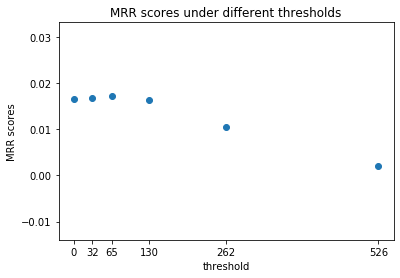

In [0]:
mrr_threshold_overall = [mrr_threshold4[0],mrr_threshold4[1],mrr_threshold4[2],
              mrr_threshold3[2],mrr_threshold2[2],mrr_threshold[2]]
x = [0,32,65,130,262,526]
y1 = mrr_threshold_overall
 
plt.scatter(x, y1)
 
plt.title('MRR scores under different thresholds')
plt.xlabel('threshold')
plt.ylabel('MRR scores')
plt.xticks(x)

plt.show()

#Question 6

In [0]:
#fraction_ratings_5,mrr_bestModel,implicit_model_best_imp
for i in np.arange(0.1,0.9,0.1):
  for j in np.arange(0.1,1-i,0.1):

    class comb_sum_123:

      def __init__(self, numitems):
        self.predictions=np.zeros(numitems)
        
      #uid is the user we are requesting recommendations for;
      #returns an array of scores, one for each item
      def predict(self, uid):
        k = 1-i-j
        user_sum = i * FractionModel(num_items).predict(uid) + j * mrr_bestModel.predict(uid) + k * implicit_model_best_imp.predict(uid)
        self.predictions = np.array(user_sum)
        return(self.predictions)
    print("When i, j, k is equal to :",i,j,k,"the MRR score is:",mrr_score(comb_sum_123(num_items),validation,k=100).mean())


When i, j, k is equal to : 0.1 0.1 0.30000000000000004 the MRR score is: 0.22831014882266495
When i, j, k is equal to : 0.1 0.2 0.30000000000000004 the MRR score is: 0.23319562506355093
When i, j, k is equal to : 0.1 0.30000000000000004 0.30000000000000004 the MRR score is: 0.23270893197310594
When i, j, k is equal to : 0.1 0.4 0.30000000000000004 the MRR score is: 0.23480639056368846
When i, j, k is equal to : 0.1 0.5 0.30000000000000004 the MRR score is: 0.23144607865325817
When i, j, k is equal to : 0.1 0.6 0.30000000000000004 the MRR score is: 0.2310130036170885
When i, j, k is equal to : 0.1 0.7000000000000001 0.30000000000000004 the MRR score is: 0.22865593652946428
When i, j, k is equal to : 0.1 0.8 0.30000000000000004 the MRR score is: 0.22857809475165003
When i, j, k is equal to : 0.2 0.1 0.30000000000000004 the MRR score is: 0.22922658163563578
When i, j, k is equal to : 0.2 0.2 0.30000000000000004 the MRR score is: 0.23482591872667208
When i, j, k is equal to : 0.2 0.3000000

In [0]:
class comb_sum_123:

  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
        
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    
    user_sum = 0.6 * FractionModel(num_items).predict(uid) + 0.1 * mrr_bestModel.predict(uid) + 0.3 * implicit_model_best_imp.predict(uid)
    self.predictions = np.array(user_sum)
    return(self.predictions)

In [20]:
#The best model with question 1,2,3 for weighting(0.6,0.1,0.3)
MRR_best_weighting_combination123 = mrr_score(comb_sum_123(num_items),test_dataset,k=100).mean()
MRR_best_weighting_combination123

0.24484064300644603

In [0]:
#fraction_ratings_5,mrr_bestModel,Lift_model
for i in np.arange(0.1,0.9,0.1):
  for j in np.arange(0.1,1-i,0.1):

    class comb_sum_125:

      def __init__(self, numitems):
        self.predictions=np.zeros(numitems)
        
      #uid is the user we are requesting recommendations for;
      #returns an array of scores, one for each item
      def predict(self, uid):
        
        user_sum = i * FractionModel(num_items).predict(uid) + j * mrr_bestModel.predict(uid) + (1-i-j) * lift_Model(num_items,0).predict(uid)
        self.predictions = np.array(user_sum)
        return(self.predictions)
    print("When i, j, k is equal to :",i,j,(1-i-j),"the MRR score is:",mrr_score(comb_sum_125(num_items),validation,k=100).mean())


In [0]:
#fraction_ratings_5,implicit_model_best_imp,Lift_model
for i in np.arange(0.1,0.9,0.1):
  for j in np.arange(0.1,1-i,0.1):

    class comb_sum_135:

      def __init__(self, numitems):
        self.predictions=np.zeros(numitems)
        
      #uid is the user we are requesting recommendations for;
      #returns an array of scores, one for each item
      def predict(self, uid):
        
        user_sum = i * FractionModel(num_items).predict(uid) + j * implicit_model_best_imp.predict(uid) + (1-i-j) * lift_Model(num_items,0).predict(uid)
        self.predictions = np.array(user_sum)
        return(self.predictions)
    print("When i, j, k is equal to :",i,j,(1-i-j),"the MRR score is:",mrr_score(comb_sum_135(num_items),validation,k=100).mean())


In [0]:
#mrr_bestModel,implicit_model_best_imp,Lift_model
for i in np.arange(0.1,0.9,0.1):
  for j in np.arange(0.1,1-i,0.1):

    class comb_sum_235:

      def __init__(self, numitems):
        self.predictions=np.zeros(numitems)
        
      #uid is the user we are requesting recommendations for;
      #returns an array of scores, one for each item
      def predict(self, uid):
        
        user_sum = i * mrr_bestModel.predict(uid) + j * implicit_model_best_imp.predict(uid) + (1-i-j) * lift_Model(num_items,0).predict(uid)
        self.predictions = np.array(user_sum)
        return(self.predictions)
    print("When i, j, k is equal to :",i,j,(1-i-j),"the MRR score is:",mrr_score(comb_sum_235(num_items),validation,k=100).mean())

In [15]:
#Because the running time of cycle is too long, so I want to try the single time for random weights
class comb_sum_235:

  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
        
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    user_sum = 0.3 * mrr_bestModel.predict(uid) + 0.5 * implicit_model_best_imp.predict(uid) + 0.2 * lift_Model(num_items,0).predict(uid)
    self.predictions = np.array(user_sum)
    return(self.predictions)
print("When w1,w2,w3 is equal to :",0.3,0.5,0.2,"the MRR score is:",mrr_score(comb_sum_235(num_items),validation,k=100).mean())

The number of books the user 0 have rated is : 67
The number of all books is: 1826
The number of books the user 1 have rated is : 84
The number of all books is: 1826
The number of books the user 2 have rated is : 73
The number of all books is: 1826
The number of books the user 3 have rated is : 66
The number of all books is: 1826
The number of books the user 4 have rated is : 43
The number of all books is: 1826
The number of books the user 5 have rated is : 23
The number of all books is: 1826
The number of books the user 6 have rated is : 130
The number of all books is: 1826
The number of books the user 7 have rated is : 79
The number of all books is: 1826
The number of books the user 8 have rated is : 47
The number of all books is: 1826
The number of books the user 9 have rated is : 40
The number of all books is: 1826
The number of books the user 10 have rated is : 64
The number of all books is: 1826
The number of books the user 11 have rated is : 76
The number of all books is: 1826
T

In [0]:
class comb_sum_235:

  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
        
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    user_sum = 0.4 * mrr_bestModel.predict(uid) + 0.3 * implicit_model_best_imp.predict(uid) + 0.3 * lift_Model(num_items,0).predict(uid)
    self.predictions = np.array(user_sum)
    return(self.predictions)
print("When w1,w2,w3 is equal to :",0.3,0.5,0.2,"the MRR score is:",mrr_score(comb_sum_235(num_items),validation,k=100).mean())

In [0]:
class comb_sum_235:

  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
        
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    user_sum = 0.5 * mrr_bestModel.predict(uid) + 0.1 * implicit_model_best_imp.predict(uid) + 0.4 * lift_Model(num_items,0).predict(uid)
    self.predictions = np.array(user_sum)
    return(self.predictions)
print("When w1,w2,w3 is equal to :",0.3,0.5,0.2,"the MRR score is:",mrr_score(comb_sum_235(num_items),validation,k=100).mean())

In [23]:
#The best model with question 2,3,5 for weighting(0.3,0.5,0.2)
MRR_best_weighting_combination235 = mrr_score(comb_sum_235(num_items),test_dataset,k=100).mean()
MRR_best_weighting_combination235

0.392346578221023

#Question 7

In [0]:
# #In the seventh question, combining all the previous experimental results, first of all, I think efficiency and effectiveness should be considered when choosing
# the recommendation system, because only by combining the two aspects of evaluation can the best recommendation system be selected. From the above experimental 
# results, it can be seen that the recommended effect is the best after combining the optimal implicit factorization model and the optimal factorization model 
# to train the data set, and the running time is very short, but there are some contingencies, for example, the implicit matrix model is more tolerant of 
# noise data.

# However, when I add different weights to the combination of different models in question 6, the effectiveness improved compared with the previous single model 
# prediction, but the efficiency is really low. Therefore, I suggest to use the validation set to select the best parameters of different models firstly, but the
# models need to choose the ones with higher operation efficiency. In the comprehensive experiment, I will choose the explicit factorization model and the implicit
# factorization model, because they are much more efficient than the lift model, and the MRR scores are also close. Then the two models are combined and 
# different weights are added to fit until the best MRR score is obtained. Secondly, I think some mathematical skills can be added to reduce the computational 
# complexity when aiming at the implicit factorization model, in order to further improve the efficiency and meet the demand of online computing. Finally, I 
# believe that when fitting the implicit data, we need to perform some operations on the data set, such as centralization, to reduce the impact of noise data
# on the model fitting.

# After this experiment, I have more understanding of the recommendation system. First of all, I think the key of recommendation system is how to find 
# users' interests and recommend relevant products to users according to users' interests. I think there are many ways to evaluate a recommendation system, but a 
# real recommendation system should use its immediacy as a key evaluation factor. Secondly, I think the recommendation system needs to constantly classify and 
# analyze the commodity information, user information and user behavior, so that we can fit the model to more effective data. In addition, when choosing different
# models, I believe that while considering efficiency and effectiveness, we should adopt various mathematical models and machine learning methods to continuously 
# improve the efficiency and effectiveness of the model. Finally, in terms of the analysis of the results predicted by various models, I think a lot of 
# classification and visualization are needed for better analysis of the results to improve the accuracy of the recommendation system.

# Overall, I think a perfect recommendation system needs to obtain users' long-term preference and short-term preference, which pay more attention to users' 
# preference changes in different time and space. As a result, short-term preference should be used primarily as an auxiliary analysis of long-term preference.
